In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [2]:

IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10


In [5]:

# path to your dataset directory
dataset_dir = 'c:\\Users\\Asus\\Desktop\\DL-PotatoDisease\\training\\Potato'

# Print the absolute path to verify it
print(f"Dataset directory: {dataset_dir}")

# Check if the directory exists
if os.path.exists(dataset_dir):
    # List the contents of the dataset directory to verify the structure
    print(f"Contents of the dataset directory: {os.listdir(dataset_dir)}")
else:
    print(f"Directory does not exist: {dataset_dir}")


Dataset directory: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato
Contents of the dataset directory: ['Early', 'Healthy', 'Late']


In [6]:

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Print class names to verify
print(f"Class names: {dataset.class_names}")

Found 2383 files belonging to 3 classes.
Class names: ['Early', 'Healthy', 'Late']


In [7]:
#Get Classes
class_names=dataset.class_names
class_names

['Early', 'Healthy', 'Late']

In [8]:
#Get length
len(dataset)

75

In [9]:
#get dimension of first image
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


In [10]:
# Debug: Print out all file paths and their corresponding labels
print("Checking all file paths and labels:")
for image_batch, label_batch in dataset:
    for img, lbl in zip(image_batch, label_batch):
        img_idx = int(lbl)
        class_name = dataset.class_names[img_idx]
        print(f"File path: {dataset.file_paths[img_idx]},Label: {img_idx}, Class name: {class_name}")

Checking all file paths and labels:
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\516099d5-5399-4d6e-916d-014a84a02a18___RS_LB 4118.JPG,Label: 2, Class name: Late
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\516099d5-5399-4d6e-916d-014a84a02a18___RS_LB 4118.JPG,Label: 2, Class name: Late
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\516099d5-5399-4d6e-916d-014a84a02a18___RS_LB 4118.JPG,Label: 2, Class name: Late
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\3b241fa8-12f2-4c80-afe2-0a4cdc8f34a1___RS_LB 5138.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\3b241fa8-12f2-4c80-afe2-0a4cdc8f34a1___RS_LB 5138.JPG,Label: 0, Class name: Early
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\training\Potato\Late\516099d5-5399-4d6e-916d-014a84a02a18___RS_LB 4118.JPG,Label: 2, Class name: Late
File path: c:\Users\Asus\Desktop\DL-PotatoDisease\

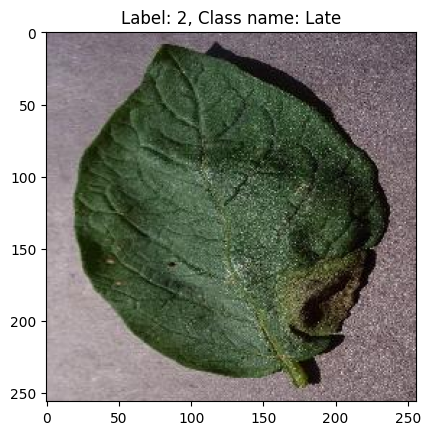

In [11]:
#Visualizing data
#Get 1st image
for image_batch, label_batch in dataset.take(1):
    image = Image.open(dataset.file_paths[1])
    plt.imshow(image)
    plt.title(f"Label: {label_batch[1].numpy()}, Class name: {dataset.class_names[label_batch[1].numpy()]}")
    plt.show()

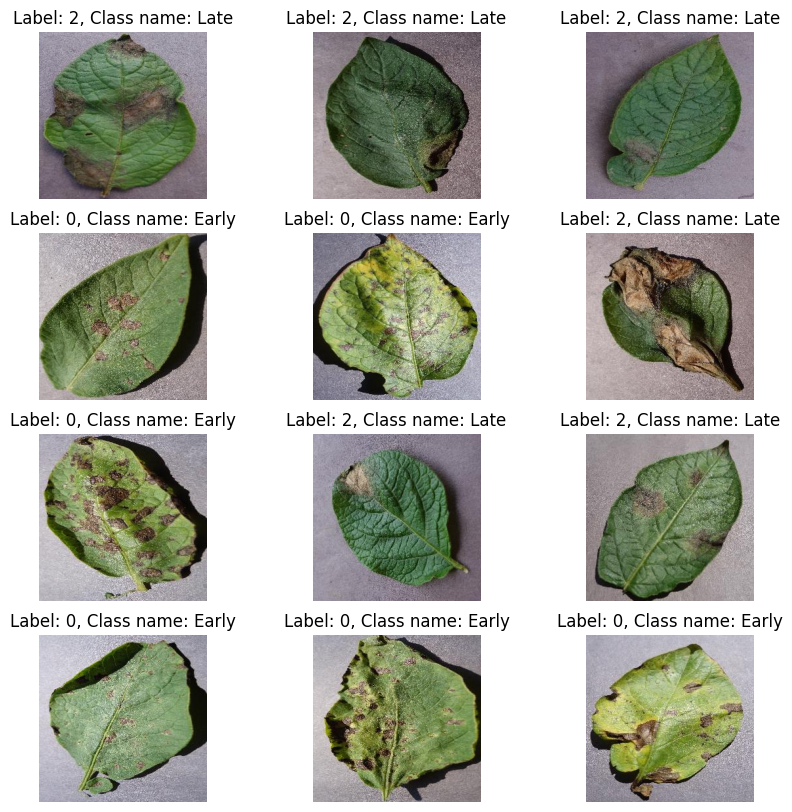

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(4,3,i+1)
        plt.imshow(Image.open(dataset.file_paths[i]))
        plt.title(f"Label: {label_batch[i].numpy()}, Class name: {dataset.class_names[label_batch[i].numpy()]}")
        plt.axis("off")

In [20]:
#Train split data
#80%=training
#20%=10% validation+ 10% testing

In [21]:
len(dataset)

75

In [22]:
#calculate 80% of training data
train_size=0.8
len(dataset)*train_size

60.0

In [23]:
#Get it into training dataset
train_ds=dataset.take(60)
len(train_ds)

60

In [24]:
#calculate 20% of remaining data
test_ds=dataset.skip(60)
len(test_ds)

15

In [25]:
#calculate 10% of validation data
val_size=0.1
len(dataset)*val_size

7.5

In [26]:
#Get it into validation dataset
val_ds=test_ds.take(7)
len(val_ds)

7

In [27]:
#Get it into testing dataset
test_ds=test_ds.skip(7)
len(test_ds)

8

In [13]:
#Train split data with the help of function
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

60

In [16]:
len(val_ds)

7

In [17]:
len(test_ds)

8

In [18]:
#Optimizing the performance 
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
#preprocessing taking care of scaling and sizing
resize_and_rescale=tf.keras.Sequential ([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
    ])


In [20]:
#Augmentation
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2),
])


In [21]:
#building model for CNN
#Defining architecture
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=3
model=Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
#Printing the summary of model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 127, 127, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 62, 62, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 30, 30, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 14, 14, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 6, 6, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 2, 2, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,44

 Total params: 185,155 (723.26 KB)

 Trainable params: 184,451 (720.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [23]:
#Compiling the architecture
model.compile (
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)


In [24]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [25]:
#Train network
history =model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3929 - loss: 1.3203 - val_accuracy: 0.4241 - val_loss: 1.0807
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4163 - loss: 1.0911 - val_accuracy: 0.4196 - val_loss: 1.0444
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4628 - loss: 1.0309 - val_accuracy: 0.4152 - val_loss: 1.0678
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4716 - loss: 1.0239 - val_accuracy: 0.4330 - val_loss: 1.0220
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4501 - loss: 1.0188 - val_accuracy: 0.4196 - val_loss: 1.0572
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4616 - loss: 1.0095 - val_accuracy: 0.4196 - val_loss: 1.1047
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4967 - loss: 0.9986 - val_accuracy: 0.4286 - val_loss: 1.0572
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4947 - loss: 0.9920 - val_accuracy: 0.3884 - val_loss

In [26]:
#testing by test data
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.4150 - loss: 1.0948


In [27]:
#displaying loss and accuracy for test
scores

[1.1175405979156494, 0.41015625]

In [28]:
#callback history access
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 60}

In [30]:
#gets all the keys of history
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
#array of accuracy in history
history.history['accuracy']

[0.3988439440727234,
 0.43194955587387085,
 0.4471886456012726,
 0.4498160779476166,
 0.4435102343559265,
 0.46978455781936646,
 0.48554912209510803,
 0.48607462644577026,
 0.47503942251205444,
 0.49500787258148193]

In [49]:
#plotting

In [32]:
#get arrays stored in different variables
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

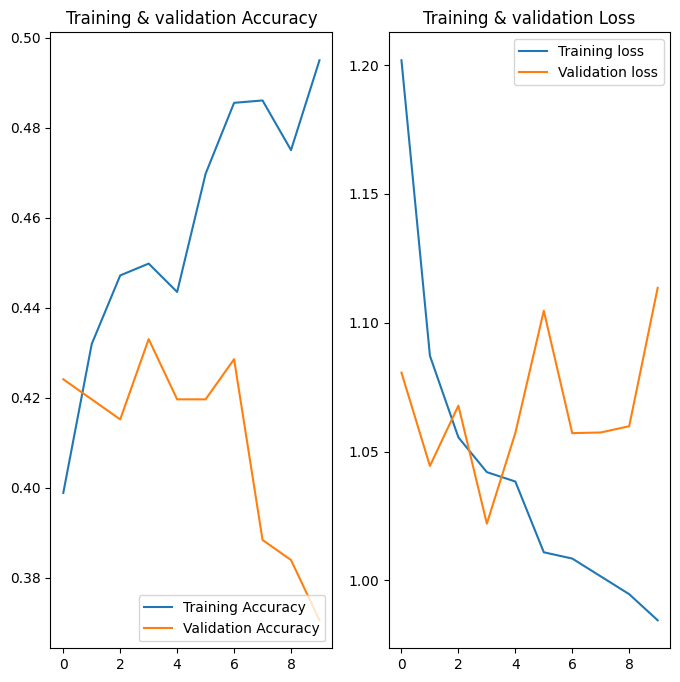

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & validation Accuracy')



plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training & validation Loss')
plt.show

First Image to predict
actual label: Late
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
Prediction label Early


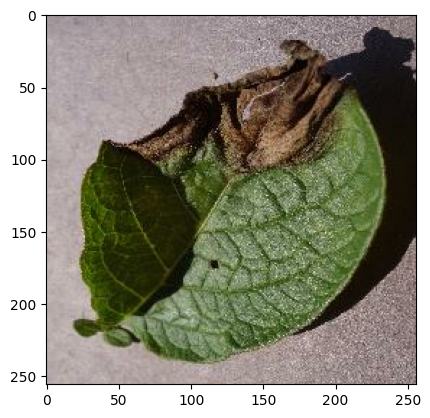

In [34]:
#Making prediction
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_img=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()
    print("First Image to predict")
    plt.imshow(first_img)
    print ("actual label:",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print("Prediction label",class_names[np.argmax(batch_prediction[0])])
